In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_error


# Import data

In [29]:
# gdpnow = pd.read_csv('test_set.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
# # Ensure that load_df index is in the same date format
# gdpnow.index = pd.to_datetime(gdpnow.index)

## Let's define X and y

In [30]:
# #Target S&P
# Target = 'SPX Index '
# Drop = ['Final_GDP_Interp','Quarter being forecasted', 'Advance Estimate From BEA',
#         'Publication Date of Advance Estimate','Days until advance estimate', 'Forecast Error', 'Data releases', 'NDX Index ', 'SPX Index ']

# # Target USDJPY
# Target = 'USDJPY Curncy'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'USDJPY Curncy']

# Target 2y Interest Rates
Target = 'USOSFR2 Curncy'
Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
       'Days until advance estimate', 'Forecast Error', 'Data releases', 'USOSFR2 Curncy', 'USOSFR10 Curncy']

# # Target WTI Oil
# Target = 'CL1 Comdty'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'CL1 Comdty']

# #Target GDP
# Target = 'Final_GDP_Interp'
# Drop = ['GDP Nowcast', 'Final_GDP_Interp', 'Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#       'Days until advance estimate', 'Forecast Error', 'Data releases']

# Load Train and Test

# Defining X and y

We now need the X and Y from the whole train and predict set that includes btm_gdp

In [31]:
# Splitting into test and train sets

train = pd.read_csv('train_set.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
X_train = train.drop(columns=Drop)
y_train = train[Target]

test = pd.read_csv('predict_set_w_btm.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
X_test = test.drop(columns=Drop)
y_test = test[Target]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3551, 66) (3551,)
(63, 66) (63,)


In [32]:
# Concatenate features (adding X_test to the bottom of X_train)
X = pd.concat([X_train, X_test])
# Concatenate labels (adding y_test to the bottom of y_train)
y = pd.concat([y_train, y_test])

print(X.shape, y.shape)


(3614, 66) (3614,)


### Optuna with Preproc

In [33]:


# # Assuming X_dropped and y_dropped are your dataset

# def objective(trial):
#     # Suggest values for the preprocessing parameters
#     n_neighbors = trial.suggest_int('n_neighbors', 1, 3)
#     percentile = trial.suggest_int('percentile', 40, 80)

#     # Create the preprocessing pipeline with suggested parameters
#     preproc = Pipeline([
#         ('imputer', KNNImputer(n_neighbors=n_neighbors)),
#         ('scaler', RobustScaler()),
#         ('feature_selection', SelectPercentile(mutual_info_regression, percentile=percentile))
#     ])

#     X_preproc_train = preproc.fit_transform(X_train, y_train)

#     # Suggest values for the model's hyperparameters
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 5, 50),
#         'learning_rate': trial.suggest_float('learning_rate', 0.15, 0.25),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 0.0, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),
#     }

#     # Initialize and train the XGBoost regressor
#     model = xgb.XGBRegressor(**params)
#     model.fit(X_preproc_train, y_train)

#     # Make predictions on the processed test set
#     X_preproc_test = preproc.transform(X_test)
#     preds = model.predict(X_preproc_test)

#     # Evaluate the model using negative mean absolute error
#     neg_mae = -mean_absolute_error(y_test, preds)

#     return neg_mae  # Optimize for neg_MAE

# # Create and execute the Optuna study
# study = optuna.create_study(direction='maximize')  # We are minimizing the negative MAE
# study.optimize(objective, n_trials=500)  # Adjust n_trials based on computational budget

# # Print best trial results
# print("Best trial:")
# trial = study.best_trial
# print(f" Value (neg_MAE): {trial.value:.4f}")
# for key, value in trial.params.items():
#     print(f" {key}: {value}")


# Pipeline

In [34]:
# preproc = Pipeline([
#     ('imputer', KNNImputer(n_neighbors=5)),
#     ('scaler', RobustScaler())
# ])

# preproc_selector = Pipeline([
#     ('preprocessing', preproc),  # Include the preprocessing steps with PCA
#     ('feature_selection', SelectPercentile(
#         mutual_info_regression))
# ])

# Modeling

In [35]:
""" #Modeling with initial dataset

model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [10, 15, 20],
    'model__reg_alpha': [0, 0.1, 1.0],  # L1 regularization parameter (alpha)
    'model__reg_lambda': [0, 0.1, 1.0],
    'preprocessor__feature_selection__percentile' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]# L2 regularization parameter (lambda)

}

pipe = Pipeline([
     ('preprocessor', preproc_selector),
     ('model', model)
 ])

random_search = RandomizedSearchCV(
     pipe,
     param_distributions=param_distributions,
     n_iter=10,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
     scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
     cv=5,
     verbose=2,
     #random_state=42,
     n_jobs=-1  # Use all available cores
 )

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_) """

' #Modeling with initial dataset\n\nmodel = XGBRegressor(random_state=42)\n\nparam_distributions = {\n    \'model__n_estimators\': [100, 200, 300],\n    \'model__learning_rate\': [0.01, 0.1, 0.2],\n    \'model__max_depth\': [10, 15, 20],\n    \'model__reg_alpha\': [0, 0.1, 1.0],  # L1 regularization parameter (alpha)\n    \'model__reg_lambda\': [0, 0.1, 1.0],\n    \'preprocessor__feature_selection__percentile\' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]# L2 regularization parameter (lambda)\n\n}\n\npipe = Pipeline([\n     (\'preprocessor\', preproc_selector),\n     (\'model\', model)\n ])\n\nrandom_search = RandomizedSearchCV(\n     pipe,\n     param_distributions=param_distributions,\n     n_iter=10,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.\n     scoring=\'neg_mean_absolute_error\',  # Assuming MSE is the metric of interest; adjust as needed.\n     cv=5,\n     verbose=2,\n     #random_state=42,\n     n_jobs=-1  # Use all 

In [36]:
random_search.score(X_test, y_test)

NameError: name 'random_search' is not defined

In [ ]:
y_pred = random_search.predict(X_test)

# Best Parameters

In [ ]:
# trial.params

{'n_neighbors': 3,
 'percentile': 51,
 'max_depth': 18,
 'learning_rate': 0.20942459081976394,
 'n_estimators': 835,
 'min_child_weight': 4,
 'gamma': 0.5896969019019073,
 'subsample': 0.9257108822918529,
 'colsample_bytree': 0.941416612869769,
 'reg_alpha': 0.29967633514259356,
 'reg_lambda': 8.432105613686591}

# Fitting best model 

In [37]:

# Extract best parameters for preprocessing and model
best_params = study.best_trial.params
# IRS
best_params =  {'n_neighbors': 3,
 'percentile': 51,
 'max_depth': 18,
 'learning_rate': 0.20942459081976394,
 'n_estimators': 835,
 'min_child_weight': 4,
 'gamma': 0.5896969019019073,
 'subsample': 0.9257108822918529,
 'colsample_bytree': 0.941416612869769,
 'reg_alpha': 0.29967633514259356,
 'reg_lambda': 8.432105613686591}


# GDP
# best_params = {
#     'n_neighbors': 3,
#     'percentile': 49,
#     'max_depth': 9,
#     'learning_rate': 0.2498773755675101,
#     'n_estimators': 1099,
#     'min_child_weight': 5,
#     'gamma': 4.948772788547994e-05,
#     'subsample': 0.8451156656189625,
#     'colsample_bytree': 0.6148165960748299,
#     'reg_alpha': 0.3365824497976371,
#     'reg_lambda': 3.450245765937823
# }

# S&P Best Params
# best_params =  {'n_neighbors': 2,
#  'percentile': 49,
#  'max_depth': 5,
#  'learning_rate': 0.2468099773819122,
#  'n_estimators': 852,
#  'min_child_weight': 7,
#  'gamma': 0.18297032462072674,
#  'subsample': 0.564931447174437,
#  'colsample_bytree': 0.5568967667312782,
#  'reg_alpha': 0.2224244648875362,
#  'reg_lambda': 6.111158890486282}

# Create the optimal preprocessing pipeline
preproc_optimal = Pipeline([
    ('imputer', KNNImputer(n_neighbors=best_params['n_neighbors'])),
    ('scaler', RobustScaler()),
    ('feature_selection', SelectPercentile(mutual_info_regression, percentile=best_params['percentile']))
])

# Create the model with optimal parameters
model_optimal = xgb.XGBRegressor(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    min_child_weight=best_params['min_child_weight'],
    gamma=best_params['gamma'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda']
)

# # Combine into a single pipeline
# pipe_optimal = Pipeline([
#     ('preprocessing', preproc_optimal),
#     ('model', model_optimal)
# ])


In [38]:
# Combine into a single pipeline
pipe_best = Pipeline([
    ('preprocessing', preproc_optimal),
    ('model', model_optimal)
])

# Fit the optimal pipeline to the full set
pipe_best.fit(X, y)

# Assuming X_train and y_train are already defined and contain your training data
score = cross_val_score(pipe_best, X, y, cv=5, scoring='neg_mean_absolute_error')


# Printing the standard deviation and mean of the cross-validation scores
print(score.std())
print(score.mean())

0.43518639383717184
-0.7240255292149341


# Predictions on X_test

In [39]:
y_pred = pipe_best.predict(X_test)

In [40]:
y_pred = pd.Series(y_pred).reset_index(drop = True)

In [41]:
y_pred.index = y_test.index
df_plot = pd.DataFrame()
df_plot = pd.concat([y_test, y_pred], axis=1)


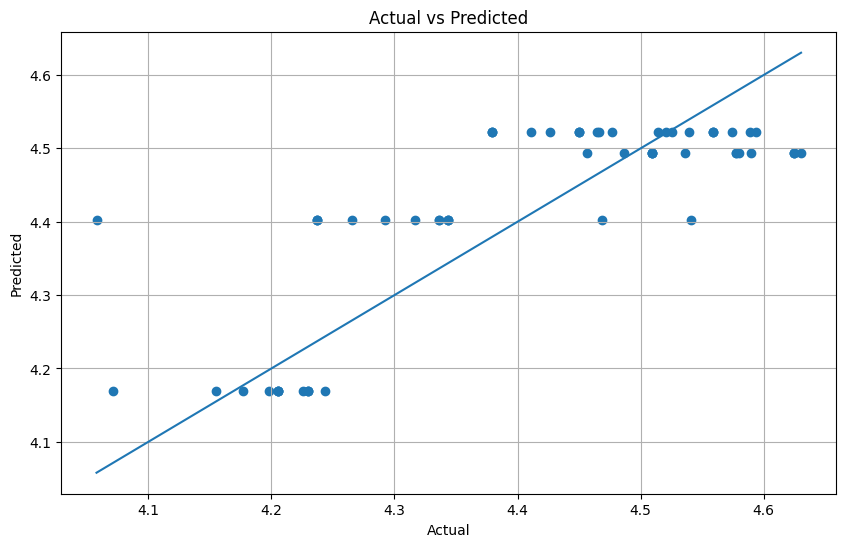

In [42]:
# Compute dynamic min and max for the line
min_val = min(df_plot[Target].min(), df_plot[0].min())
max_val = max(df_plot[Target].max(), df_plot[0].max())

# Adjust a and b dynamically
a = [min_val, max_val]
b = [min_val, max_val]

plt.figure(figsize=(10, 6))
plt.plot(a,b)
scatter = plt.scatter(df_plot[Target], df_plot[0] )
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Loss curves

[0]	validation_0-mae:0.84081	validation_1-mae:2.08604
[1]	validation_0-mae:0.60976	validation_1-mae:1.47615
[2]	validation_0-mae:0.44224	validation_1-mae:1.04457
[3]	validation_0-mae:0.32078	validation_1-mae:0.72922
[4]	validation_0-mae:0.23268	validation_1-mae:0.50330
[5]	validation_0-mae:0.16884	validation_1-mae:0.34778
[6]	validation_0-mae:0.12258	validation_1-mae:0.21991
[7]	validation_0-mae:0.08919	validation_1-mae:0.14129
[8]	validation_0-mae:0.06508	validation_1-mae:0.10674
[9]	validation_0-mae:0.04789	validation_1-mae:0.09872
[10]	validation_0-mae:0.03551	validation_1-mae:0.10222
[11]	validation_0-mae:0.02665	validation_1-mae:0.10517
[12]	validation_0-mae:0.02031	validation_1-mae:0.10873
[13]	validation_0-mae:0.01573	validation_1-mae:0.10933
[14]	validation_0-mae:0.01255	validation_1-mae:0.11178
[15]	validation_0-mae:0.01040	validation_1-mae:0.11402
[16]	validation_0-mae:0.00874	validation_1-mae:0.11562
[17]	validation_0-mae:0.00766	validation_1-mae:0.11642
[18]	validation_0-ma

/Users/thomasbowden/.pyenv/versions/lewagon/envs/project-btm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-mae:0.00525	validation_1-mae:0.11971
[23]	validation_0-mae:0.00503	validation_1-mae:0.11917
[24]	validation_0-mae:0.00488	validation_1-mae:0.11775
[25]	validation_0-mae:0.00465	validation_1-mae:0.11787
[26]	validation_0-mae:0.00452	validation_1-mae:0.11815
[27]	validation_0-mae:0.00438	validation_1-mae:0.11820
[28]	validation_0-mae:0.00425	validation_1-mae:0.11823
[29]	validation_0-mae:0.00418	validation_1-mae:0.11826
[30]	validation_0-mae:0.00409	validation_1-mae:0.11820
[31]	validation_0-mae:0.00403	validation_1-mae:0.11820
[32]	validation_0-mae:0.00398	validation_1-mae:0.11821
[33]	validation_0-mae:0.00394	validation_1-mae:0.11821
[34]	validation_0-mae:0.00391	validation_1-mae:0.11769
[35]	validation_0-mae:0.00383	validation_1-mae:0.11770
[36]	validation_0-mae:0.00379	validation_1-mae:0.11770
[37]	validation_0-mae:0.00372	validation_1-mae:0.11770
[38]	validation_0-mae:0.00367	validation_1-mae:0.11770
[39]	validation_0-mae:0.00363	validation_1-mae:0.11770
[40]	valid

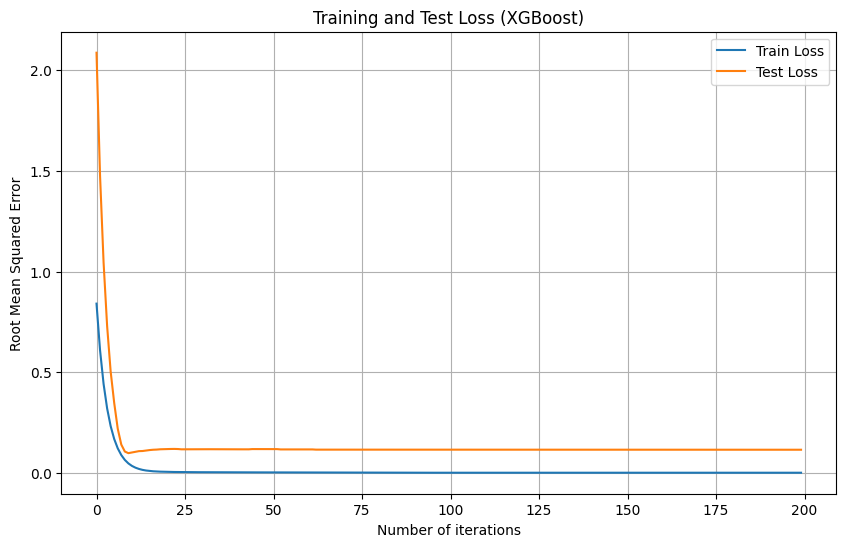

In [43]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming you have your X_train, y_train, X_test, and y_test data prepared

# Define the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(n_estimators=200, max_depth = 9, learning_rate = 0.275, random_state=42, reg_lambda = 0.01)

X_train_preproc = preproc_optimal.fit_transform(X_train, y_train)
X_test_preproc = preproc_optimal.transform(X_test)

# Fit the model with evaluation set
eval_set = [(X_train_preproc, y_train), (X_test_preproc, y_test)]
xgb_regressor.fit(X_train_preproc, y_train, eval_set=eval_set, eval_metric="mae", verbose=True)

# Extract training and validation loss from the model's history
results = xgb_regressor.evals_result()
train_loss = results['validation_0']['mae']
test_loss = results['validation_1']['mae']

# Plot the train and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Number of iterations')
plt.ylabel('Root Mean Squared Error')
plt.title('Training and Test Loss (XGBoost)')
plt.legend()
plt.grid()
plt.show()

# Predictions on Unseen data (> 19/01/2024)

In [44]:
predict_data = pd.read_csv('predict_set_w_btm.csv', index_col='Dates', parse_dates=True)

predict_data.index = pd.to_datetime(predict_data.index)

unseen_X = predict_data.drop(columns=Drop)
unseen_y = predict_data[Target]

assert(unseen_X.shape[0]==unseen_y.shape[0])

In [45]:
predictions = pipe_best.predict(unseen_X)

predictions = pd.Series(predictions)
predictions.index = unseen_y.index

df_plot = pd.DataFrame()
df_plot = pd.concat([unseen_y, predictions], axis=1)
df_plot.columns

Index(['USOSFR2 Curncy', 0], dtype='object')

In [47]:
df_plot['Mkt'] = df_plot['USOSFR2 Curncy']
df_plot['Mdl'] = df_plot[0]
df_plot['Diff'] = df_plot['USOSFR2 Curncy'] - df_plot[0]
df_plot = df_plot.drop(columns=['USOSFR2 Curncy', 0])


In [48]:
from sklearn.metrics import mean_absolute_error

# Assuming you have y_test and y_pred
mae = mean_absolute_error(unseen_y, predictions)
mae

0.11172227939424058

In [50]:

# plt.figure(figsize=(10, 6))

# scatter = plt.scatter(df_plot[Target], df_plot[0] )
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Actual vs Predicted')
# plt.grid(True)
# plt.show()

## Shapley Feature Test

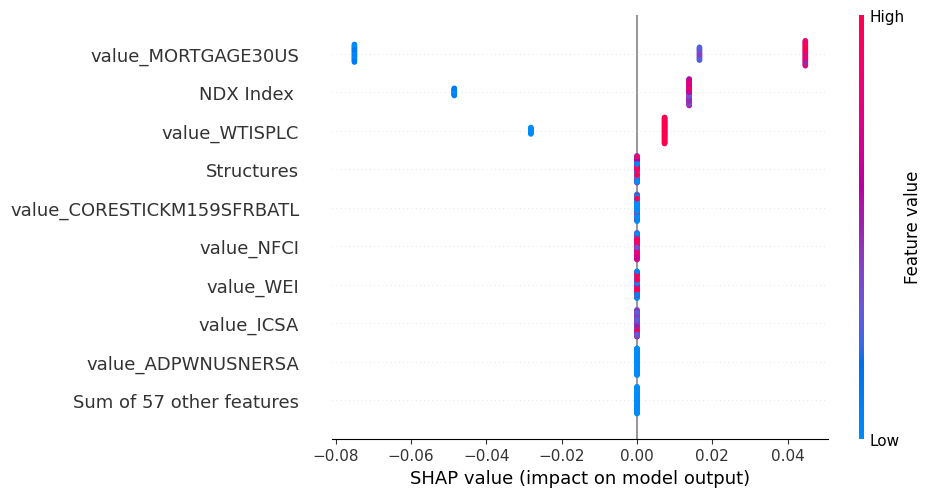

In [51]:
# Feature Selection
import shap
# Compute SHAP values
# # Initialize the explainer on the entire pipeline
explainer = shap.Explainer(pipe_best.predict, X_test)
# Compute SHAP values
shap_values = explainer(X_test)
# # Visualize the feature importance
# shap.plots.bar(shap_values)
# Plot SHAP values to understand feature importance
# shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.plots.beeswarm(shap_values)
#change

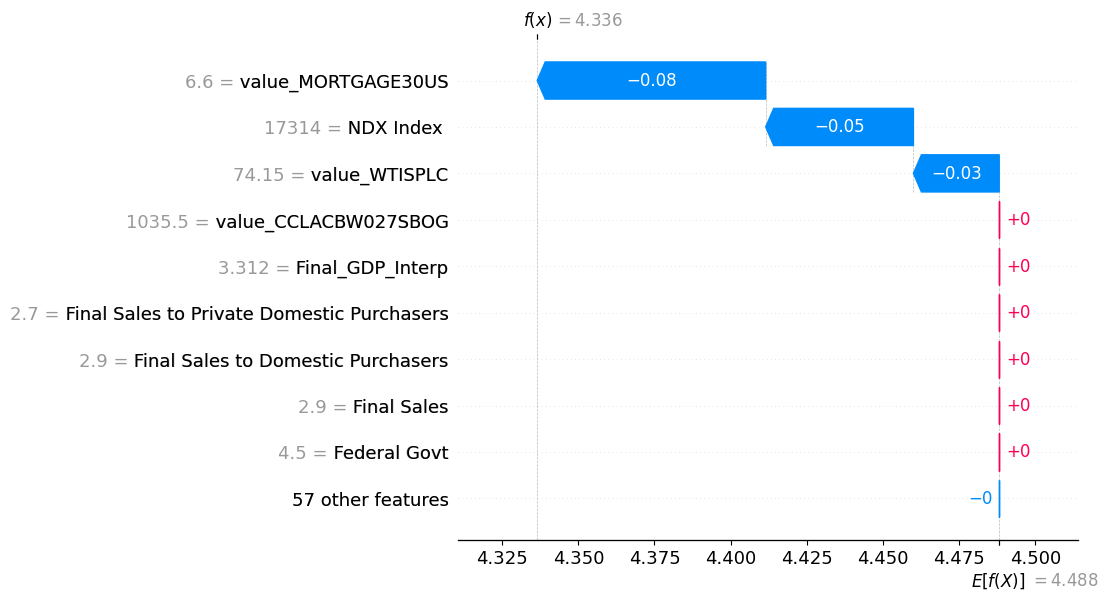

In [52]:
# Feature Selection
import shap

# Compute SHAP values
# # Initialize the explainer on the entire pipeline
explainer = shap.Explainer(pipe_best.predict, X_test)
# Compute SHAP values
shap_values = explainer(X_test)

# # Visualize the feature importance
# shap.plots.bar(shap_values)
# Plot SHAP values to understand feature importance
# shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.plots.waterfall(shap_values[0])
#change

In [53]:
import csv
csv_file = 'best_params_IRS.csv'

# Define the fieldnames for the CSV file
fieldnames = ['Parameter', 'Value']

# Write the dictionary to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write each key-value pair as a row
    for key, value in best_params.items():
        writer.writerow({'Parameter': key, 'Value': value})

print(f"CSV file '{csv_file}' has been created.")

CSV file 'best_params_IRS.csv' has been created.


### Back Test A Strategy 

In [104]:
predictions_life = pipe_best.predict(X)

predictions_life = pd.Series(predictions_life)
predictions_life.index = y.index

df_plot_life = pd.DataFrame()
df_plot_life = pd.concat([y, predictions_life], axis=1)
df_plot_life.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3614 entries, 2014-05-01 to 2024-03-21
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   USOSFR2 Curncy  3614 non-null   float64
 1   0               3614 non-null   float32
dtypes: float32(1), float64(1)
memory usage: 199.6 KB


In [105]:
# Clean the df
df_plot_life['Mkt'] = df_plot_life['USOSFR2 Curncy']
df_plot_life['Mdl'] = df_plot_life[0]
df_plot_life['Diff'] = df_plot_life['USOSFR2 Curncy'] - df_plot_life[0]
df_plot_life = df_plot_life.drop(columns=['USOSFR2 Curncy', 0])

In [106]:
df_plot_life.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3614 entries, 2014-05-01 to 2024-03-21
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt     3614 non-null   float64
 1   Mdl     3614 non-null   float32
 2   Diff    3614 non-null   float64
dtypes: float32(1), float64(2)
memory usage: 227.9 KB


In [107]:
# Calculate the Z-score for the 'Diff' column
df_plot_life['Diff Z-score'] = (df_plot_life['Diff'] - df_plot_life['Diff'].mean()) / df_plot_life['Diff'].std()

df_plot_life[['Diff', 'Diff Z-score']].head(10)  # Displaying the first 10 rows for inspection
# df_plot_life.columns, df_plot_life.shape

,Diff,Diff Z-score
Dates,,
2014-05-01,-0.04443,-0.194775
2014-05-02,-0.02343,-0.059230
2014-05-03,-0.02343,-0.059230
2014-05-04,-0.02343,-0.059230
2014-05-05,-0.01393,0.002088
2014-05-06,-0.01493,-0.004367
2014-05-07,-0.03493,-0.133457
2014-05-08,-0.04293,-0.185093
2014-05-09,-0.04593,-0.204457


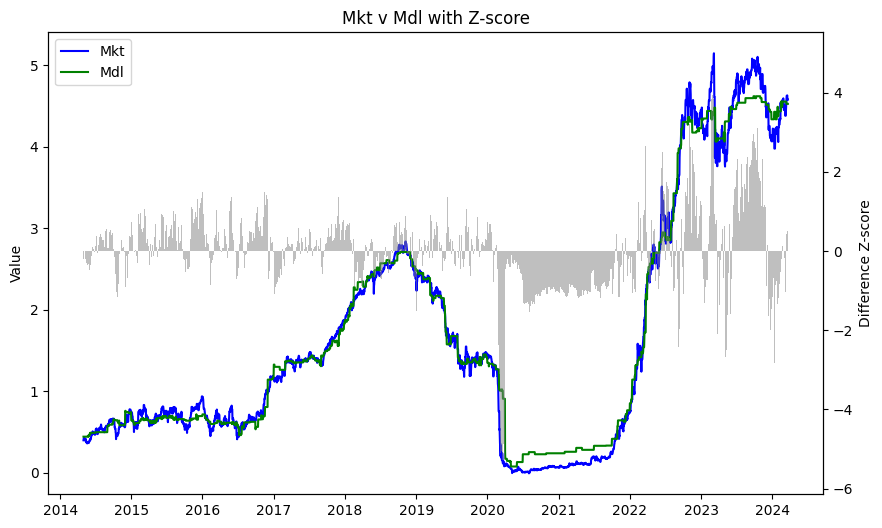

In [122]:
import matplotlib.pyplot as plt

# Creating a plot with two y-axes for the entire df_plot_life DataFrame
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line charts for 'Mkt' and 'Mdl'
ax1.plot(df_plot_life.index, df_plot_life['Mkt'], label='Mkt', color='blue')
ax1.plot(df_plot_life.index, df_plot_life['Mdl'], label='Mdl', color='green')
ax1.set_ylabel('Value')
ax1.legend(loc='upper left')

# Creating a twin axis for the 'Diff Z-score' bar chart
ax2 = ax1.twinx()
ax2.bar(df_plot_life.index, df_plot_life['Diff Z-score'], label='Diff Z', color='gray', alpha=0.5, width=1)
ax2.set_ylabel('Difference Z-score')
ax2.grid(False)

plt.title('Mkt v Mdl with Z-score')
plt.show()


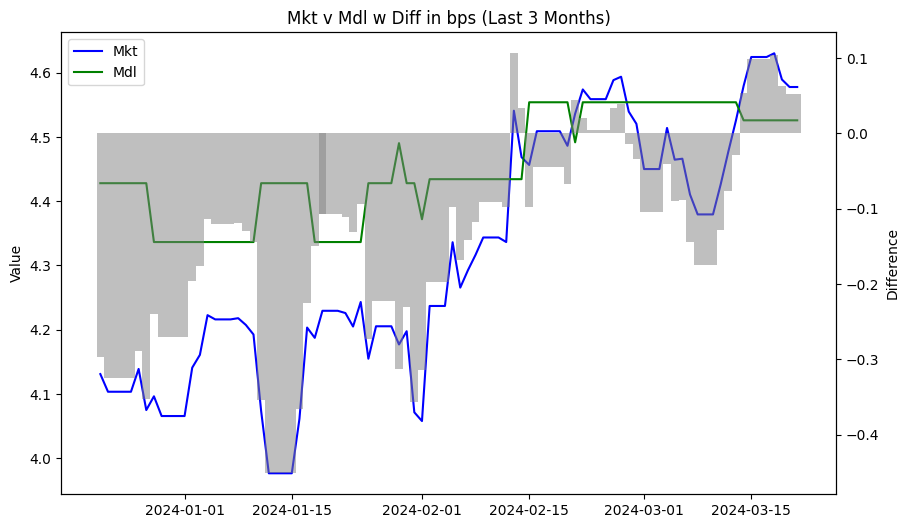

In [120]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_plot_life is already defined and has a DateTimeIndex
# Calculate the cutoff date for the last 3 months
cutoff_date = df_plot_life.index.max() - pd.DateOffset(months=3)

# Filter the DataFrame to include only the last 3 months
df_last_3_months = df_plot_life[df_plot_life.index >= cutoff_date]

# Creating a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line charts for 'Mkt' and 'Mdl' using the filtered DataFrame
ax1.plot(df_last_3_months.index, df_last_3_months['Mkt'], label='Mkt', color='blue')
ax1.plot(df_last_3_months.index, df_last_3_months['Mdl'], label='Mdl', color='green')
ax1.set_ylabel('Value')
ax1.legend(loc='upper left')

# Creating a twin axis for the 'Diff' bar chart
ax2 = ax1.twinx()
ax2.bar(df_last_3_months.index, df_last_3_months['Diff'], label='Diff', color='gray', alpha=0.5, width=1)
ax2.set_ylabel('Difference')
ax2.grid(False)

plt.title('Mkt v Mdl w Diff in bps (Last 3 Months)')
plt.show()


In [112]:
import statsmodels.api as sm

# Perform Augmented Dickey-Fuller test
adf_result = sm.tsa.adfuller(df_plot_life['Diff'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -7.400378
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Based on the output of the Augmented Dickey-Fuller (ADF) test you've shared, here's the interpretation:

ADF Statistic: -7.400378. This is the calculated value of the test statistic.
p-value: 0.000000. This value indicates the probability of observing the test results under the null hypothesis. A low p-value (typically < 0.05) suggests that you can reject the null hypothesis.
Critical Values: These values are used to compare with the ADF statistic to determine the stationarity of the series at different confidence levels.
1%: -3.432
5%: -2.862
10%: -2.567
Given that the ADF statistic is significantly lower than the critical values at all common confidence levels (1%, 5%, and 10%), and the p-value is effectively 0, you can reject the null hypothesis that your series ('Diff' between the model prediction and the market values) has a unit root.

Conclusion: The 'Diff' series is stationary, suggesting that the differences between the model prediction and the market values do not follow a random walk and are mean-reverting. This implies that any deviations from the mean are temporary and the series will revert to its mean over time, which can be a useful property in various financial and econometric analyses.

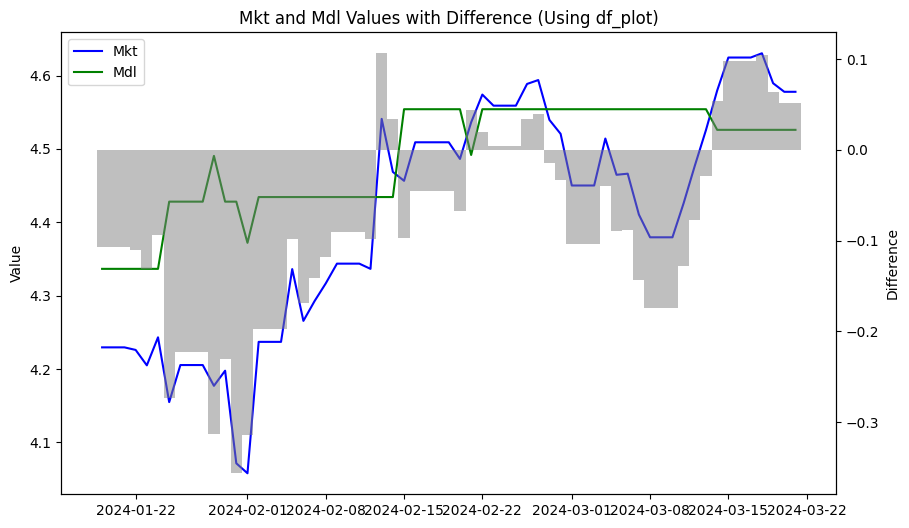

In [98]:
import matplotlib.pyplot as plt

# Creating a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line charts for 'Mkt' and 'Mdl'
ax1.plot(df_plot.index, df_plot['Mkt'], label='Mkt', color='blue')
ax1.plot(df_plot.index, df_plot['Mdl'], label='Mdl', color='green')
ax1.set_ylabel('Value')
ax1.legend(loc='upper left')

# Creating a twin axis for the 'Diff' bar chart
ax2 = ax1.twinx()
ax2.bar(df_plot.index, df_plot['Diff'], label='Diff Z', color='gray', alpha=0.5, width=1)
ax2.set_ylabel('Difference')
ax2.grid(False)

plt.title('Mkt and Mdl Values with Difference (Using df_plot)')
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [102]:
import pandas as pd
import numpy as np


# Strategy thresholds
threshold_T = 0.2  # Threshold to initiate a trade
threshold_L = 0.3  # Loss threshold
threshold_W = 0.1  # Win threshold

# Initializing the strategy column
df_plot_life['Strategy'] = None

for index in range(len(df_plot_life)):
    current_diff = df_plot_life.iloc[index]['Diff']

    # Trade initiation condition
    if abs(current_diff) >= threshold_T:
        if index == 0 or pd.isnull(df_plot_life.iloc[index - 1]['Strategy']):
            df_plot_life.at[df_plot_life.index[index], 'Strategy'] = 'T'
        elif df_plot_life.iloc[index - 1]['Strategy'] == 'L':
            if abs(current_diff) >= threshold_L:
                df_plot_life.at[df_plot_life.index[index], 'Strategy'] = 'L'
            elif abs(current_diff) <= threshold_W:
                df_plot_life.at[df_plot_life.index[index], 'Strategy'] = 'W'
            continue

    # If trade is live
    if index > 0 and df_plot_life.iloc[index - 1]['Strategy'] in ['T', 'L']:
        df_plot_life.at[df_plot_life.index[index], 'Strategy'] = 'L'
        # Check for stop or take profit
        if abs(current_diff) >= threshold_L:
            df_plot_life.at[df_plot_life.index[index], 'Strategy'] = 'L'
        elif abs(current_diff) <= threshold_W:
            df_plot_life.at[df_plot_life.index[index], 'Strategy'] = 'W'

# Display the DataFrame to verify the logic
print(df_plot_life)


                Diff Strategy
Date                         
2014-05-01 -0.316387        T
2014-05-02 -0.217401        L
2014-05-03  0.473369        L
2014-05-04  0.305025        L
2014-05-05 -0.303868        L
...              ...      ...
2014-08-04 -0.217277     None
2014-08-05 -0.304150        T
2014-08-06  0.201855        L
2014-08-07  0.473891        L
2014-08-08 -0.133601        L

[100 rows x 2 columns]
